# Scrap book for testing stuff

In [100]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

## Define tickers and date span

In [101]:
ticker1_name = 'RIO'
ticker2_name = 'RIO.L'

start_date = '2020-01-01'
end_date = '2022-01-01'

## Get data

In [119]:
wifi = 1
save_data = 1

if (wifi == 1):
    ticker1 = yf.Ticker(ticker1_name)
    ticker2 = yf.Ticker(ticker2_name)

    data1 = ticker1.history(start=start_date, end=end_date, frequency='1dy')['Close'].rename(ticker1_name)
    data2 = ticker2.history(start=start_date, end=end_date, frequency='1dy')['Close'].rename(ticker2_name)

    df = pd.concat([data1, data2], axis=1).bfill()

    if (save_data == 1):
        df.to_csv('data/' + ticker1_name + '_' + ticker2_name + '.csv')
    
else:
    df = pd.read_csv('data/' + ticker1_name + '_' + ticker2_name + '.csv')
    df.columns = [ticker1_name, ticker2_name]
    df = df.bfill()

Text(0.5, 1.0, 'RIO.L')

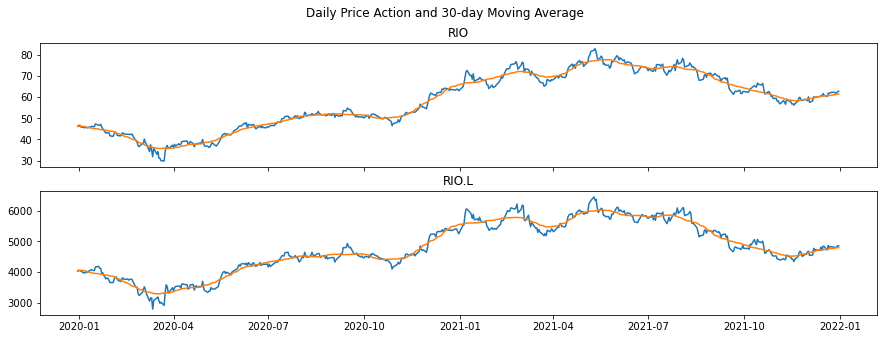

In [111]:
df_mean = pd.concat([df[ticker1_name].rolling(window=30, center=True, min_periods=0).mean(), 
                        df[ticker2_name].rolling(window=30, center=True, min_periods=0).mean()], 
                       axis=1)
df_spread = df[ticker2_name] - df[ticker1_name]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15, 5))
fig.suptitle('Daily Price Action and 30-day Moving Average')

ax1.plot(df[ticker1_name])
ax1.plot(df_mean[ticker1_name])
ax1.set_title(ticker1_name)

ax2.plot(df[ticker2_name])
ax2.plot(df_mean[ticker2_name])
ax2.set_title(ticker2_name)

## Correlation

In [112]:
corr = df.corr()
print('Price Correlation:', corr[ticker1_name][ticker2_name])

Price Correlation: 0.9760958246825493


## Johansen cointegration test

Using log-prices because makes more sense apparently

In [113]:
df_log_price = np.log10(df)
jres = coint_johansen(df_log_price, det_order=0, k_ar_diff=1)
output = pd.DataFrame([jres.lr2,jres.lr1],
                          index=['max_eig_stat',"trace_stat"])
print(output.T,'\n')
print("Critical values(90%, 95%, 99%) of max_eig_stat\n",jres.cvm,'\n')
print("Critical values(90%, 95%, 99%) of trace_stat\n",jres.cvt,'\n')

   max_eig_stat  trace_stat
0     23.252446   26.119226
1      2.866780    2.866780 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



## OLS Regression

In [114]:
# Determine cointegration coefficient
X = df[ticker1_name]
Y = df[ticker2_name]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
# Get beta coefficient: P2 = beta * P1 + alpha (alpha = 0)
beta_coef = model.params[ticker1_name]

summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  RIO.L   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.039e+04
Date:                Wed, 06 Jul 2022   Prob (F-statistic):               0.00
Time:                        13:07:31   Log-Likelihood:                -3419.2
No. Observations:                 517   AIC:                             6842.
Df Residuals:                     515   BIC:                             6851.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1195.6834     36.265     32.971      0.0

## Basic Trading intervals

Calculate spread, mean spread, and trivial trading intervals based on standard deviation from mean spread

In [115]:
df_spread = df[ticker2_name] - (df[ticker1_name] * beta_coef)
spread_mean = df_spread.mean()
spread_std = df_spread.std()

n = 1
upper = spread_mean + (n * spread_std)
lower = spread_mean - (n * spread_std)

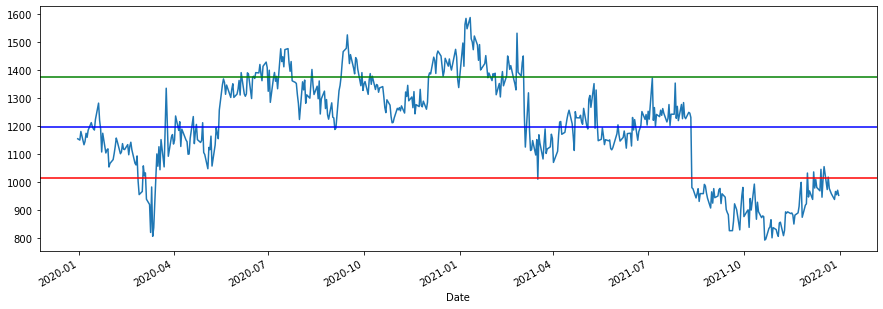

In [117]:
ax3 = df_spread.plot(figsize=(15, 5))

ax3.axhline(y=lower, color='r', linestyle='-')
ax3.axhline(y=upper, color='g', linestyle='-')
ax3.axhline(y=spread_mean, color='b', linestyle='-')

## Optimising Trading Intervals

In [ ]:
U_grid = np.linspace(0, (5*), num=50